2025-05-31 15:52:18.280338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748706738.452871      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748706738.502517      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss



=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    Negative       0.90      0.86      0.88       496
    Positive       0.87      0.91      0.89       504

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



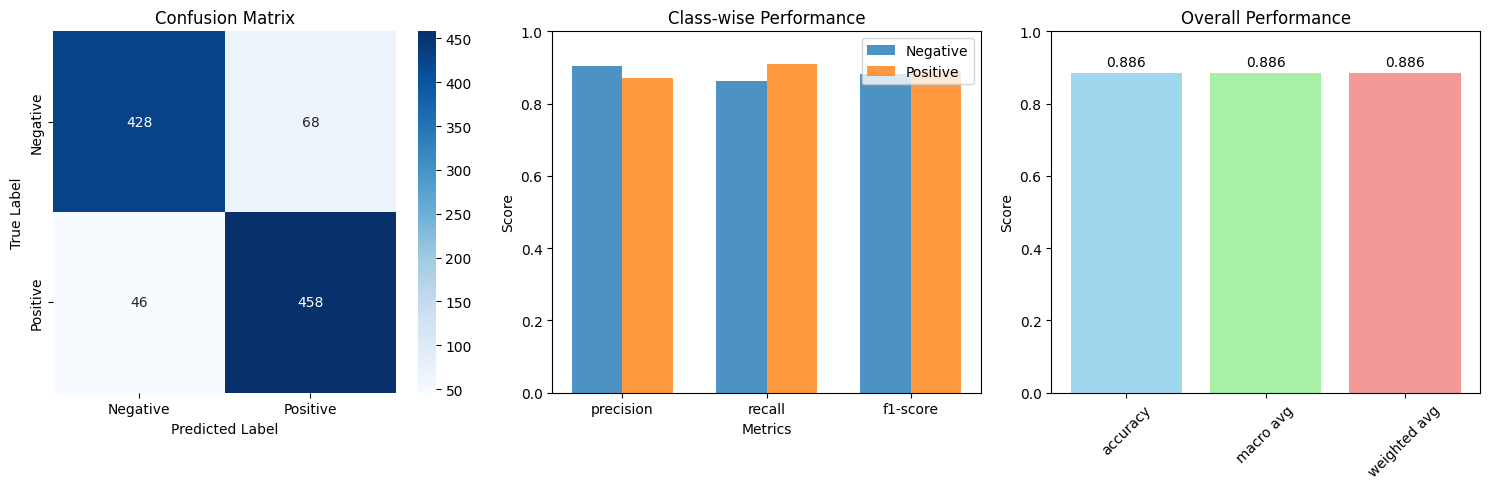


Tek Tahmin Örneği:
Metin: This movie was absolutely fantastic! I loved every minute of it.
Sentiment: Positive
Güven: 0.9242


In [1]:
import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                         Trainer, TrainingArguments, EarlyStoppingCallback)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pandas as pd
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import os
from datetime import datetime
import logging

# Uyarıları gizle
warnings.filterwarnings('ignore')

# Tokenizer parallelism uyarısını kaldır
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Logging ayarları
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class SentimentAnalyzer:
    def __init__(self, model_name="distilbert-base-uncased", max_length=256):
        """
        Sentiment Analizi sınıfı
        
        Args:
            model_name (str): Kullanılacak model adı
            max_length (int): Maksimum token uzunluğu
        """
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = None
        self.model = None
        self.trainer = None
        
        # GPU kontrolü
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"Kullanılan cihaz: {self.device}")
        
    def load_and_preprocess_data(self, file_path, sample_size=None):
        """
        Veriyi yükle ve ön işleme yap
        
        Args:
            file_path (str): CSV dosya yolu
            sample_size (int): Örneklem boyutu (None ise tüm veri)
        """
        logger.info("Veri yükleniyor...")
        df = pd.read_csv(file_path)
        
        # Örnekleme
        if sample_size and sample_size < len(df):
            df = df.sample(n=sample_size, random_state=42)
            logger.info(f"Veri {sample_size} örneğe düşürüldü")
        
        # Temel veri temizleme
        df['review'] = df['review'].apply(self.clean_text)
        df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
        
        # Veri dağılımını kontrol et
        logger.info(f"Toplam örnek sayısı: {len(df)}")
        logger.info(f"Pozitif örnekler: {(df['sentiment'] == 1).sum()}")
        logger.info(f"Negatif örnekler: {(df['sentiment'] == 0).sum()}")
        
        return df
    
    def clean_text(self, text):
        """
        Metni temizle
        
        Args:
            text (str): Ham metin
            
        Returns:
            str: Temizlenmiş metin
        """
        # HTML etiketlerini kaldır
        text = re.sub(r'<[^>]+>', ' ', text)
        # Özel karakterleri kaldır (sadece harf, rakam ve temel noktalama bırak)
        text = re.sub(r'[^\w\s.,!?-]', ' ', text)
        # Çoklu boşlukları tek boşluğa çevir
        text = re.sub(r'\s+', ' ', text)
        # Baş ve son boşlukları kaldır
        text = text.strip()
        return text
    
    def prepare_datasets(self, df, test_size=0.2, val_size=0.1):
        """
        Veriyi train/validation/test olarak ayır ve tokenize et
        
        Args:
            df (pd.DataFrame): Veri çerçevesi
            test_size (float): Test seti oranı
            val_size (float): Validation seti oranı
        """
        logger.info("Veri setleri hazırlanıyor...")
        
        # Stratified split kullanarak dengeli ayırma
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
        train_idx, test_idx = next(sss.split(df['review'], df['sentiment']))
        
        train_data = df.iloc[train_idx]
        test_data = df.iloc[test_idx]
        
        # Validation seti oluştur
        if val_size > 0:
            sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=42)
            train_idx, val_idx = next(sss_val.split(train_data['review'], train_data['sentiment']))
            
            val_data = train_data.iloc[val_idx]
            train_data = train_data.iloc[train_idx]
        else:
            val_data = None
        
        # Dataset objelerine çevir
        self.train_dataset = Dataset.from_pandas(train_data.reset_index(drop=True))
        self.test_dataset = Dataset.from_pandas(test_data.reset_index(drop=True))
        
        if val_data is not None:
            self.val_dataset = Dataset.from_pandas(val_data.reset_index(drop=True))
        else:
            self.val_dataset = None
        
        # Tokenize et
        self.train_dataset = self.train_dataset.map(
            self.tokenize_function, 
            batched=True,
            remove_columns=self.train_dataset.column_names  # Tüm orijinal sütunları kaldır
        )
        
        self.test_dataset = self.test_dataset.map(
            self.tokenize_function, 
            batched=True,
            remove_columns=self.test_dataset.column_names
        )
        
        if self.val_dataset is not None:
            self.val_dataset = self.val_dataset.map(
                self.tokenize_function, 
                batched=True,
                remove_columns=self.val_dataset.column_names
            )
        
        # Dataset formatını ayarla
        self.train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        self.test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        
        if self.val_dataset is not None:
            self.val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        
        logger.info(f"Train seti: {len(self.train_dataset)} örnek")
        if self.val_dataset:
            logger.info(f"Validation seti: {len(self.val_dataset)} örnek")
        logger.info(f"Test seti: {len(self.test_dataset)} örnek")
    
    def load_model(self):
        """Model ve tokenizer'ı yükle"""
        logger.info(f"Model yükleniyor: {self.model_name}")
        
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name, 
            num_labels=2,
            problem_type="single_label_classification"
        )
        
        # Modeli GPU'ya taşı
        self.model.to(self.device)
        
        # Padding token ekle (gerekirse)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
    
    def tokenize_function(self, examples):
        """Tokenizasyon fonksiyonu"""
        tokenized = self.tokenizer(
            examples["review"], 
            padding="max_length", 
            truncation=True,
            max_length=self.max_length,
            return_tensors=None  # "pt" yerine None kullan
        )
        
        # Label'ı manuel olarak ekle
        tokenized["labels"] = examples["sentiment"]
        
        return tokenized
    
    def compute_metrics(self, eval_pred):
        """Değerlendirme metriklerini hesapla"""
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        
        accuracy = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average='weighted')
        
        return {
            'accuracy': accuracy,
            'f1': f1
        }
    
    def train_model(self, epochs=3, learning_rate=2e-5, batch_size=16, 
                   early_stopping_patience=3, save_model=True, use_wandb=False, 
                   wandb_project_name="sentiment-analysis"):
        """
        Modeli eğit
        
        Args:
            epochs (int): Epoch sayısı
            learning_rate (float): Öğrenme oranı
            batch_size (int): Batch boyutu
            early_stopping_patience (int): Early stopping sabır
            save_model (bool): Modeli kaydet
            use_wandb (bool): Wandb kullan
            wandb_project_name (str): Wandb proje adı
        """
        logger.info("Model eğitimi başlıyor...")
        
        # Çıktı dizinini oluştur
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = f'./results_{timestamp}'
        os.makedirs(output_dir, exist_ok=True)
        
        # Wandb ayarları
        if use_wandb:
            try:
                import wandb
                # Wandb'yi başlat
                wandb.init(
                    project=wandb_project_name,
                    name=f"sentiment-analysis-{timestamp}",
                    config={
                        "model_name": self.model_name,
                        "learning_rate": learning_rate,
                        "batch_size": batch_size,
                        "epochs": epochs,
                        "max_length": self.max_length
                    }
                )
                report_to = "wandb"
                run_name = f"sentiment-analysis-{timestamp}"
            except ImportError:
                logger.warning("Wandb yüklü değil, wandb tracking devre dışı")
                report_to = "none"
                run_name = None
        else:
            # Wandb'yi tamamen devre dışı bırak
            os.environ["WANDB_DISABLED"] = "true"
            report_to = "none"
            run_name = None
        
        # Training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            run_name=run_name,  # Wandb uyarısını çözer
            eval_strategy="steps",
            eval_steps=200,
            save_steps=200,
            logging_steps=100,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size * 2,
            gradient_accumulation_steps=2,
            fp16=torch.cuda.is_available(),  # Sadece GPU varsa
            num_train_epochs=epochs,
            warmup_ratio=0.1,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1",
            greater_is_better=True,
            save_total_limit=2,
            dataloader_num_workers=0,  # Fork sorunu için 0 yap
            remove_unused_columns=True,  # True olarak değiştir
            report_to=report_to,  # Wandb kontrolü
        )
        
        # Callback'ler
        callbacks = []
        if early_stopping_patience > 0:
            callbacks.append(EarlyStoppingCallback(early_stopping_patience=early_stopping_patience))
        
        # Trainer oluştur
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.val_dataset if self.val_dataset else self.test_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=callbacks,
        )
        
        # Eğitimi başlat
        train_result = self.trainer.train()
        
        # Eğitim sonuçlarını kaydet
        if save_model:
            self.trainer.save_model(output_dir)
            logger.info(f"Model kaydedildi: {output_dir}")
        
        # Wandb'yi kapat
        if use_wandb:
            try:
                import wandb
                wandb.finish()
            except:
                pass
        
        return train_result
    
    def evaluate_model(self, dataset_name="test"):
        """Modeli değerlendir"""
        logger.info(f"Model değerlendiriliyor ({dataset_name} seti)...")
        
        dataset = self.test_dataset if dataset_name == "test" else self.val_dataset
        
        # Tahminleri al
        predictions = self.trainer.predict(dataset)
        preds = np.argmax(predictions.predictions, axis=-1)
        labels = predictions.label_ids
        
        # Metrikleri hesapla
        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='weighted')
        
        logger.info(f"Accuracy: {accuracy:.4f}")
        logger.info(f"F1 Score: {f1:.4f}")
        
        return preds, labels, accuracy, f1
    
    def plot_results(self, preds, labels, save_fig=True):
        """Sonuçları görselleştir"""
        # Classification report
        report = classification_report(labels, preds, 
                                     target_names=["Negative", "Positive"],
                                     output_dict=True)
        
        print("\n=== CLASSIFICATION REPORT ===")
        print(classification_report(labels, preds, 
                                  target_names=["Negative", "Positive"]))
        
        # Confusion Matrix
        conf_matrix = confusion_matrix(labels, preds)
        
        plt.figure(figsize=(15, 5))
        
        # Confusion Matrix
        plt.subplot(1, 3, 1)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=["Negative", "Positive"], 
                    yticklabels=["Negative", "Positive"])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        
        # Metrik karşılaştırması
        plt.subplot(1, 3, 2)
        metrics = ['precision', 'recall', 'f1-score']
        negative_scores = [report['Negative'][metric] for metric in metrics]
        positive_scores = [report['Positive'][metric] for metric in metrics]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        plt.bar(x - width/2, negative_scores, width, label='Negative', alpha=0.8)
        plt.bar(x + width/2, positive_scores, width, label='Positive', alpha=0.8)
        
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('Class-wise Performance')
        plt.xticks(x, metrics)
        plt.legend()
        plt.ylim(0, 1)
        
        # Genel performans
        plt.subplot(1, 3, 3)
        overall_metrics = ['accuracy', 'macro avg', 'weighted avg']
        overall_scores = [report['accuracy'], 
                         report['macro avg']['f1-score'],
                         report['weighted avg']['f1-score']]
        
        colors = ['skyblue', 'lightgreen', 'lightcoral']
        bars = plt.bar(overall_metrics, overall_scores, color=colors, alpha=0.8)
        
        # Bar üzerinde değerleri göster
        for bar, score in zip(bars, overall_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.title('Overall Performance')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        
        if save_fig:
            plt.savefig(f'sentiment_analysis_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', 
                       dpi=300, bbox_inches='tight')
            logger.info("Sonuç grafiği kaydedildi")
        
        plt.show()
    
    def predict_single(self, text):
        """Tek bir metin için tahmin yap"""
        if self.trainer is None:
            raise ValueError("Model henüz eğitilmedi!")
        
        # Metni temizle ve tokenize et
        cleaned_text = self.clean_text(text)
        inputs = self.tokenizer(cleaned_text, 
                               padding="max_length", 
                               truncation=True,
                               max_length=self.max_length,
                               return_tensors="pt")
        
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Tahmin yap
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(predictions, dim=-1).item()
            confidence = predictions[0][predicted_class].item()
        
        sentiment = "Positive" if predicted_class == 1 else "Negative"
        
        return {
            'text': text,
            'sentiment': sentiment,
            'confidence': confidence,
            'probabilities': {
                'negative': predictions[0][0].item(),
                'positive': predictions[0][1].item()
            }
        }

def main():
    """Ana fonksiyon"""
    # Sentiment analyzer oluştur
    analyzer = SentimentAnalyzer(model_name="distilbert-base-uncased", max_length=256)
    
    # Veriyi yükle (Kaggle path'ini kendi path'iniz ile değiştirin)
    df = analyzer.load_and_preprocess_data("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
    
    # Örnek kullanım (küçük veri seti ile test)
    df = analyzer.load_and_preprocess_data("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv", sample_size=5000)
    
    # Model ve tokenizer yükle
    analyzer.load_model()
    
    # Veri setlerini hazırla
    analyzer.prepare_datasets(df, test_size=0.2, val_size=0.1)
    
    # Modeli eğit (wandb ile veya wandb olmadan)
    analyzer.train_model(epochs=2, batch_size=16, early_stopping_patience=2, use_wandb=False)
    #analyzer.train_model(epochs=2, batch_size=16, early_stopping_patience=2, use_wandb=True, wandb_project_name="my-sentiment-project")
    
    # Modeli değerlendir
    preds, labels, accuracy, f1 = analyzer.evaluate_model()
    
    # Sonuçları görselleştir
    analyzer.plot_results(preds, labels)
    
    # Tek tahmin örneği
    result = analyzer.predict_single("This movie was absolutely fantastic! I loved every minute of it.")
    print(f"\nTek Tahmin Örneği:")
    print(f"Metin: {result['text']}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Güven: {result['confidence']:.4f}")
    

if __name__ == "__main__":
    main()